#Capstone CS57 – Automatic Word Association

Import packages for data analysis and model building

In [1]:
# Import supporting packages.
# pip options used...
#   -U  Upgrade specified packages to the newest available version.
#   -q  Quiet; give less output.

!pip install nltk -U -q

from bs4 import BeautifulSoup
from gensim.models import FastText, KeyedVectors, Word2Vec
from google.colab import drive
from scipy import spatial

import datetime
import gc
import itertools
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import re
import seaborn
import string
import warnings

nltk.download('punkt', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('maxent_ne_chunker', quiet=True)
nltk.download('words', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet')
  
# Environmental configuration.
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=FutureWarning)
GDRIVE_ROOT = "/content/drive"

# # Miscellaneous constants.
FILEPATH_GOOGLE_PRETRAINED_MODEL = "GoogleNews-vectors-negative300.bin"

     |████████████████████████████████| 1.5MB 6.5MB/s 


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Mount Google Drive so that corpus can be read from disk

In [0]:
# Mount the Google Drive, but only if not already mounted.
mount_point = os.path.expanduser(GDRIVE_ROOT)
already_mounted = os.path.isdir(os.path.join(mount_point, "My Drive"))
if not already_mounted:
  drive.mount(GDRIVE_ROOT)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


##Loading Corpus from Disk

In [0]:
def suffix(num):
  if num == 0:
    return ""
  else:
    return str(num)

def filepath(num):
  return os.path.join(mount_point, "My Drive", "WordAssociation", "token{}.txt".format(suffix(num)))

corpusnum = 0


# Find the latest corpus file in the WordAssociation directory
while True:
  if not os.path.isfile(filepath(corpusnum)):
    break
  corpusnum += 1


# Corpus number selection override (Uncomment this line to select a particular corpus file)

# corpusnum = 4


if corpusnum > 0:
  with open(filepath(corpusnum - 1)) as f:
    corpus = [line.strip().split(' ') for line in f.readlines()]

else:
  print(filepath(0), 'not found')

  

## Training Word2Vec and fastText models

###Training the models

In [0]:
# Declare a dictionary to store a range of models.
# Note that all of the gensim family of models assume a min_count=5.
# I.e. rare words will be dropped.
gensim_model = {}

In [0]:
%%time

# Train a (CBOW) Word2Vec model.
gensim_model['wv_cbow'] = Word2Vec(corpus, sg = 0, iter = 10)

CPU times: user 3min 1s, sys: 771 ms, total: 3min 2s
Wall time: 1min 8s


In [0]:
%%time

# Train a (skip-gram) Word2Vec model.
gensim_model['wv_sg'] = Word2Vec(corpus, sg = 1, size=100, iter=20)

CPU times: user 16min 54s, sys: 1.27 s, total: 16min 55s
Wall time: 5min 42s


In [0]:
%%time

# Train a (CBOW) FastText model.
gensim_model['ft_cbow'] = FastText(corpus, sg = 0, iter = 10)

CPU times: user 13min 52s, sys: 986 ms, total: 13min 53s
Wall time: 4min 46s


In [0]:
%%time

# Train a (skip-gram) FastText model.
gensim_model['ft_sg'] = FastText(corpus, sg = 1, size=200, iter = 30)

CPU times: user 49min 22s, sys: 2.5 s, total: 49min 25s
Wall time: 16min 38s


In [0]:
word_vectors = {k: v.wv for k, v in gensim_model.items()}

In [0]:
!pip install glove_python

     |████████████████████████████████| 266kB 2.9MB/s 
  Created wheel for glove-python: filename=glove_python-0.1.0-cp36-cp36m-linux_x86_64.whl size=700324 sha256=3c8f322a1205d3af149ca40055b24109e297ff9fbbae5a7324ab41a58fa5ffef
  Stored in directory: /root/.cache/pip/wheels/88/4b/6d/10c0d2ad32c9d9d68beec9694a6f0b6e83ab1662a90a089a4b
Successfully built glove-python


In [0]:
from glove import Corpus, Glove

corpus = Corpus()
corpus.fit(corpus, window=10)

glove = Glove(no_components=5, learning_rate=0.05) 
glove.fit(corpus.matrix, epochs=20, no_threads=4, verbose=True)
glove.add_dictionary(corpus.dictionary)
glove.save('glove.model')

Performing 20 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19


In [0]:
glove_vectors = {k: glove.word_vectors[v] for k, v in glove.dictionary.items()}

In [0]:
word_vectors['glove'] = glove_vectors

### Reading Human Evaluation File

In [0]:
human_eval_file = '/content/drive/My Drive/WordAssociation/human_judgement.xlsx'

human_eval_xls = {}
corr_score = {}
eval_sheets = ["Pedersen's", "Hliaoutakis's", 'mayosrs', 'umnsrs']
for sheet_name in eval_sheets :
  human_eval_xls[sheet_name] = pd.read_excel(human_eval_file, sheet_name = sheet_name).dropna()

In [0]:
def multiword_similarity(model, term1, term2):
  def phrase_vec(term):
    words_in_phrase = term.split(' ')
    return sum([model[word] if word in model else np.nan for word in words_in_phrase])/ len(words_in_phrase)

  
  return np.sum(phrase_vec(term1) * phrase_vec(term2)) / \
  (np.linalg.norm(phrase_vec(term1)) * np.linalg.norm(phrase_vec(term2)))

In [0]:

for model_name in word_vectors.keys():
  for sheet_name in eval_sheets:
    human_eval_xls[sheet_name][model_name] = \
    human_eval_xls[sheet_name].apply(lambda x: 
                                    multiword_similarity(word_vectors[model_name], x['Term 1'].lower(), x['Term 2'].lower()), axis = 1)

In [0]:
from scipy import stats

def correlation_measure(method) :
  correlations = []  
  corr_sheet = pd.Series([])
  for sheet in eval_sheets:
    similarities = human_eval_xls[sheet].set_index(['Term 1', 'Term 2']).dropna()
    if method.find('Pearson') > -1 :
      corr_sheet = similarities.apply(lambda x: stats.pearsonr(similarities['Physician'], x)[0])
    elif method.find('Spearman') > -1 : 
      corr_sheet = similarities.apply(lambda x: stats.spearmanr(similarities['Physician'], x)[0])
    
    corr_sheet.name = sheet
    correlations.append(corr_sheet)
  df = pd.concat(correlations, axis = 1)
  return df


In [0]:
print('Pearson Correlation \n')
correlation_measure('Pearson')

Pearson Correlation 



,Pedersen's,Hliaoutakis's,mayosrs,umnsrs
Physician,1.000000,1.000000,1.000000,1.000000
EHR20,0.460737,0.429745,0.120243,0.267349
EHR60,0.576060,0.448266,0.259808,0.329326
EHR100,0.643086,0.466208,0.426620,0.465430
PM20,0.407315,0.127672,0.149011,0.131757
PM60,0.648207,0.369030,0.270753,0.389501
PM100,0.419210,0.298786,0.192974,0.377554
Wiki(50),0.347893,0.309994,-0.055959,0.172077
Wiki100,0.439649,0.340491,0.011273,0.138697
GoogleNews,0.475497,0.463928,0.047699,0.288681


In [0]:
print('Spearman Correlation \n')
correlation_measure('Spearman')

Spearman Correlation 



,Pedersen's,Hliaoutakis's,mayosrs,umnsrs
Physician,1.000000,1.000000,1.000000,1.000000
EHR20,0.463373,0.422407,0.144008,0.278175
EHR60,0.591109,0.446283,0.268323,0.334624
EHR100,0.609609,0.451180,0.429202,0.453223
PM20,0.421088,0.234467,0.119051,0.204511
PM60,0.677441,0.428835,0.254092,0.409268
PM100,0.351935,0.256085,0.134423,0.356122
Wiki(50),0.384970,0.297828,-0.070107,0.154870
Wiki100,0.449376,0.320479,-0.020218,0.104156
GoogleNews,0.488039,0.461893,0.034923,0.292901


In [0]:
terms = ['virus', 'digestion', 'stomach', 'tuberculosis']

In [0]:
def calculate_similarity(list_medical, model, model_label="", verbose=False):

  # Calculate term similarities and store them in a Pandas data frame.
  # N.B. Similarity is determined via cosine similarity.

  if (len(model_label) > 0):
    print("Similarity calculations for model: " + model_label + ".\n")

  if (verbose == True):
    print("Similarity calculations commenced.")

  dfSimilarity = pd.DataFrame(columns = list_medical, index = list_medical)
  for termx in list_medical:
    dfSimilarity[termx] = pd.Series([model.wv.similarity(termx, termy) \
                            for termy in list_medical], index = list_medical)

  if (verbose == True):
    print("Similarity calculations complete.")
    print(datetime.datetime.now().strftime("%d-%b-%Y %H:%M:%S") + "\n")

  return dfSimilarity

In [0]:
calculate_similarity(terms, gensim_model['wv_sg'])

,virus,digestion,stomach,tuberculosis
virus,1.000000,0.195793,0.190373,0.468021
digestion,0.195793,1.000000,0.136486,0.101961
stomach,0.190373,0.136486,1.000000,0.120113
tuberculosis,0.468021,0.101961,0.120113,1.000000


In [0]:
# Get the frequency of each word in the (skip-gram) Word2Vec model.

word_counts = {}
for word in gensim_model['wv_sg'].wv.vocab:
  word_counts[word] = gensim_model['wv_sg'].wv.vocab[word].count

In [0]:
# Display the top 61-121 most frequent words in the (skip-gram) Word2Vec model.
print(pd.Series(word_counts).sort_values(ascending = False).iloc[60:120])

overall        6184
nodes          6144
found          6077
positive       6067
higher         6024
progression    5954
case           5925
bone           5912
n              5899
median         5830
studies        5809
conclusion     5759
however        5717
response       5670
one            5608
factor         5597
liver          5568
conclusions    5563
performed      5463
control        5455
treated        5455
resection      5388
gene           5370
age            5320
tissue         5285
gastric        5199
time           5175
background     5140
prostate       5090
prognosis      5078
melanoma       5042
potential      5018
including      4795
surgical       4692
activity       4658
malignant      4518
colorectal     4515
tumour         4506
cd             4450
mice           4436
development    4411
review         4408
model          4395
total          4384
identified     4350
ci             4317
effects        4298
level          4259
different      4256
status         4209


##PCA

In [0]:
# Build list of the words and their corresponding vectors in the
# (skip-gram) Word2Vec model.

vector_list = []
word_list = []
for word in gensim_model['ft_sg'].wv.vocab:
  vector_list.append(gensim_model['ft_sg'].wv[word])
  word_list.append(word)

# Each word vector is stored as an array of floating point values.
# Join (stack) these arrays.
X_ours = np.stack(vector_list)

# For each array's n-th value, subtract the mean of every array's n-th value.
# I.e. normalise around zero.
X_ours -= np.mean(X_ours, axis = 0)

X_ours.shape

(28451, 200)

In [0]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def top_frequent_words(model, top):
  
  """
  For an input model, retrieve the "top" most frequent words.
  """

  words = model.wv.index2entity[:top]
  #words = [lemmatizer.lemmatize(w) for w in model.wv.index2entity[:top]]
  words = list(dict.fromkeys(words))
  
  return words

In [0]:
# Define some test terms to appear on PCA plots.

medical_words = ['blood', 'cells', 'diabetes', 'glucose', 'infection', \
                 'insulin', 'malaria', 'metabolic', 'serum', 'tumor']
non_medical_words = ['company', 'government', 'information', 'people', 'play', \
                     'points', 'state', 'time', 'week', 'year']
len(medical_words), len(non_medical_words)


# top 200 frequent words, get 50 medical words
top_300_words = top_frequent_words(gensim_model['ft_sg'], 300)
#print(top_300_words)

medical_words = ['patient', 'cancer', 'tumor', 'metastasis', 'cell', 'treatment', 'carcinoma', 'lymph', 'metastatic', 'disease',
                 'clinical', 'therapy', 'lung', 'prognostic', 'chemotherapy', 'surgery', 'protein', 'tomography', 'diagnosis', 'bone', 
                 'liver', 'treated', 'gene', 'tissue', 'gastric', 'prostate', 'prognosis', 'melanoma', 'surgical', 'malignant', 
                 'colorectal', 'receptor', 'lesion', 'blood', 'therapeutic', 'thyroid', 'molecular', 'radiotherapy', 'acid', 'serum', 
                 'proliferation','adenocarcinoma','pancreatic','squamous','brain','biopsy','management','cervical','diagnosed','adjuvant']
non_medical_words = [item for item in top_300_words if item not in medical_words]
non_medical_words = non_medical_words[0:50]

In [0]:
X_ours.shape

(28451, 200)

In [0]:
def reduce_dimensionality(X, sv = 2):
  
  """
  Perform dimensionality reduction via singluar value decomposition.
  """

  U, S, Vt = np.linalg.svd(X, full_matrices = False)
  return X @ Vt[:sv].T

In [0]:
# Get the first two principal components of the normalised vectors.
pca_ours = reduce_dimensionality(X_ours, 2)

medical_indexes_ours = [word_list.index(word) for word in medical_words]
non_medical_indexes_ours = [word_list.index(word) for word in non_medical_words]


In [0]:
def plot_terms(pca, vocab, term_list, model_name):

  """
  Render a PCA plot.
  """
  
  indexes = [vocab.index(word) for word in term_list]
  fig, ax = plt.subplots(figsize=(10,10))

  plt.scatter(pca[indexes, 0], pca[indexes, 1], s = 50)
  plt.xlabel('PCA dimension 1')
  plt.ylabel('PCA dimension 2')
  
  # Move the title a little higher than the default.
  # (The default positioning is hard to read)
  plt.title('PCA of vectors produced by ' + model_name, pad = 15)

  # Move point labels further away from the points.
  # (The default positioning is hard to read.)
  for i, word in enumerate(term_list):
    ax.annotate(word, tuple(pca[indexes[i]]), xytext=(6, 2), \
                textcoords='offset points', fontSize=10)

  # Major gridlines.
  ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

  ax.axis('equal')

  return None

In [0]:
# Add support for downloading files into Colaboratory.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
mydrive = GoogleDrive(gauth)

In [0]:
# Download Google's pre-trained Word2Vec model.
# Key features...
#   - ~1.5 GB
#   - word vectors for ~3 million words and phrases.
#   - was trained on a Google News dataset of ~1 billion words.
#   - vector length = 300.

downloaded = mydrive.CreateFile({"id": "1cOEYOQRd1VXi7ROShhqZbioCcePvgnR5"})
downloaded.GetContentFile(FILEPATH_GOOGLE_PRETRAINED_MODEL)

In [0]:
# Instantiate Google's pre-trained Word2Vec model.
# Only import 100,000 of the ~3 million word vectors.
# The full corpus may crash a Colab session.
gensim_model['gn_wv_model'] = KeyedVectors.load_word2vec_format( \
                       FILEPATH_GOOGLE_PRETRAINED_MODEL, binary=True, \
                       limit = 1000000)

word_vectors['gn_wv_model'] = gensim_model['gn_wv_model']

# Collect the model's words.
word_list_google = list(gensim_model['gn_wv_model'].vocab)

# Collect the model's vectors.
X_google = gensim_model['gn_wv_model'][word_list_google]
print("\nX_google.shape = " + str(X_google.shape) + ".")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL



X_google.shape = (1000000, 300).


In [0]:
# Get the first two principal components of the Google word vectors.
pca_google = reduce_dimensionality(X_google, 2)

medical_indexes_google = [word_list_google.index(word) \
                          for word in medical_words if word in medical_words]
non_medical_indexes_google = [word_list_google.index(word) \
                              for word in non_medical_words if word in non_medical_words]

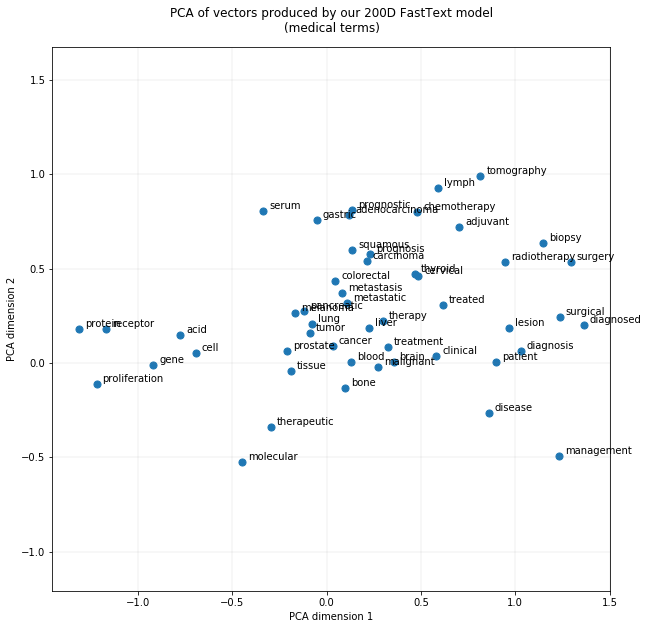

In [0]:
# Display a PCA plot of our 200-dimension (skip-gram) FastText model.
# Use the example medical terms defined earlier.
plot_terms(pca_ours, word_list, medical_words, \
           model_name = 'our 200D FastText model\n(medical terms)')

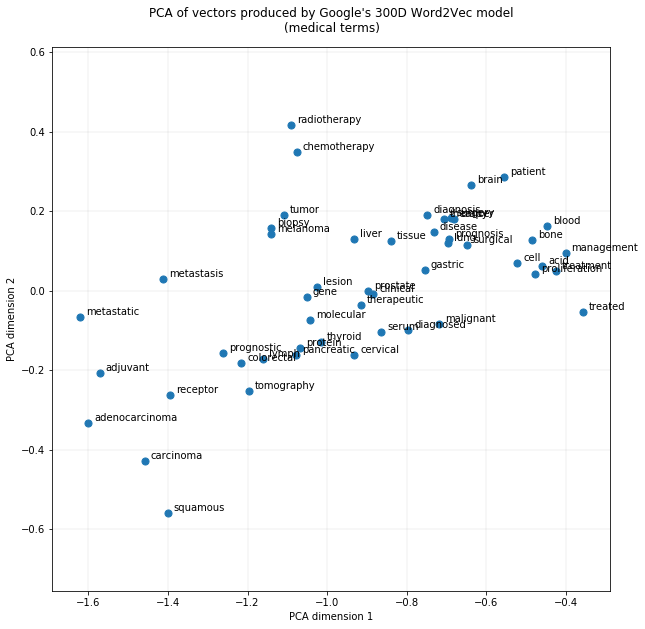

In [0]:
# Display a PCA plot of Google's 300-dimension pretrained Word2Vec model.
# Use the example medical terms defined earlier.
plot_terms(pca_google, word_list_google, medical_words, \
           model_name = "Google's 300D Word2Vec model\n(medical terms)")

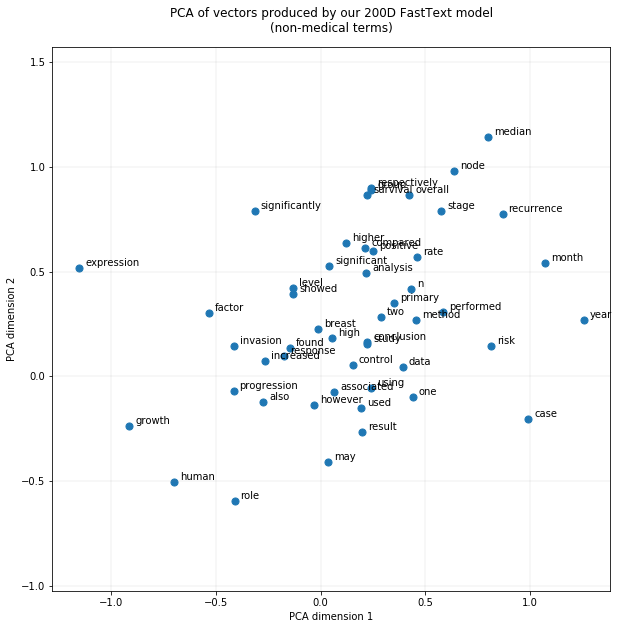

In [0]:
# Display a PCA plot of our 200-dimension (skip-gram) FastText model.
# Use the example non-medical terms defined earlier.
plot_terms(pca_ours, word_list, non_medical_words, \
           model_name = 'our 200D FastText model\n(non-medical terms)')

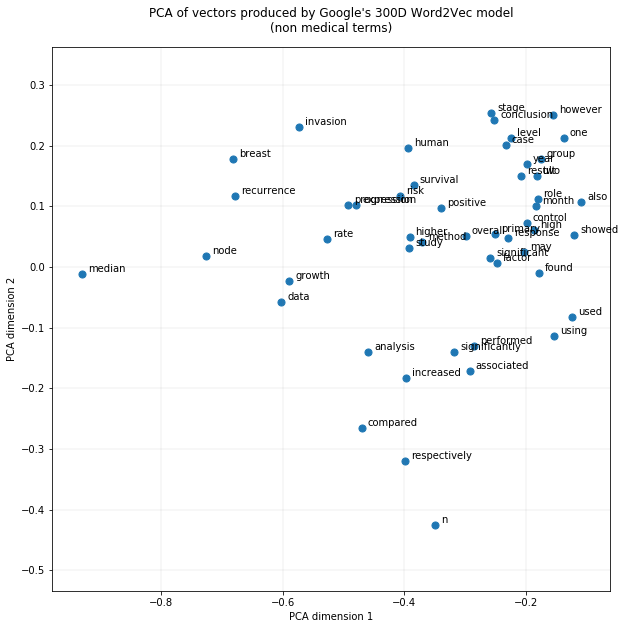

In [0]:
# Display a PCA plot of Google's 300-dimension pretrained Word2Vec model.
# Use the example non-medical terms defined earlier.
plot_terms(pca_google, word_list_google, non_medical_words, \
           model_name = "Google's 300D Word2Vec model\n(non medical terms)")

In [0]:
# Get the frequency of each word in the Google pre-trained Word2Vec model.
word_counts_google = {}
for word in gensim_model['gn_wv_model'].wv.vocab:
  word_counts_google[word] = gensim_model['gn_wv_model'].wv.vocab[word].count

##T-SNE Plot

In [0]:
from sklearn.manifold import TSNE

def display_tsnescatterplot(model, words, model_name, model_dimension):

  """
  Render a t-SNE plot.
  N.B. Points are rendered green to distinguish these plots from PCA plots.
  """

  arr = np.empty((0, model_dimension), dtype='f')
  word_labels = []
  for word in words:
    word_labels.append(word)
    arr = np.append(arr, np.array([model[word]]), axis=0)

  fig, ax = plt.subplots(figsize=(10,10))

  tsne = TSNE(n_components=2, n_iter=1000, perplexity=2)
  np.set_printoptions(suppress=True)
  Y = tsne.fit_transform(arr)
  x_coords = Y[:, 0]
  y_coords = Y[:, 1]
  plt.scatter(x_coords, y_coords, color="#00A658", s = 50)

  plt.title('t-SNE of vectors produced by ' + model_name, pad = 20)
  plt.xlabel('t-SNE dimension 1')
  plt.ylabel('t-SNE dimension 2')
  
  for label, x, y in zip(word_labels, x_coords, y_coords):
    plt.annotate(label, xy=(x, y), xytext=(6, 2), textcoords='offset points', fontSize=15)
  plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
  plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)

  # Major gridlines.
  ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

  plt.show()

  return None

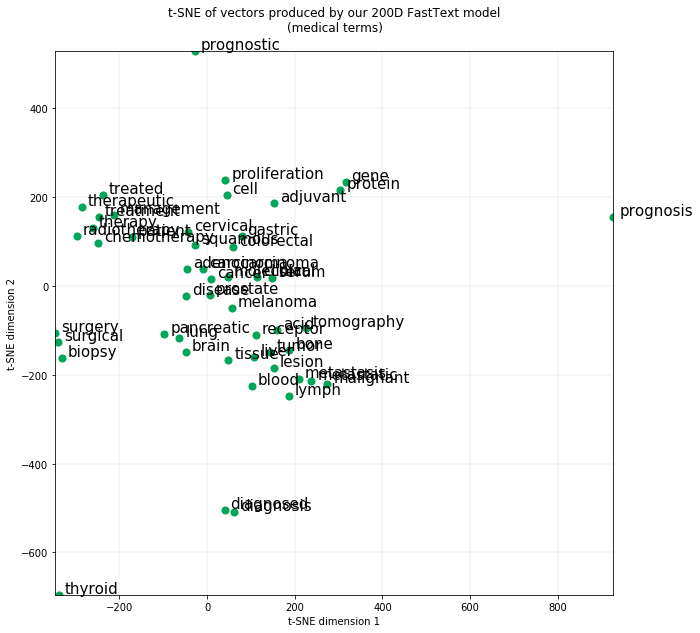

In [0]:
display_tsnescatterplot(gensim_model['ft_sg'].wv, medical_words, \
                        "our 200D FastText model\n(medical terms)", 200)

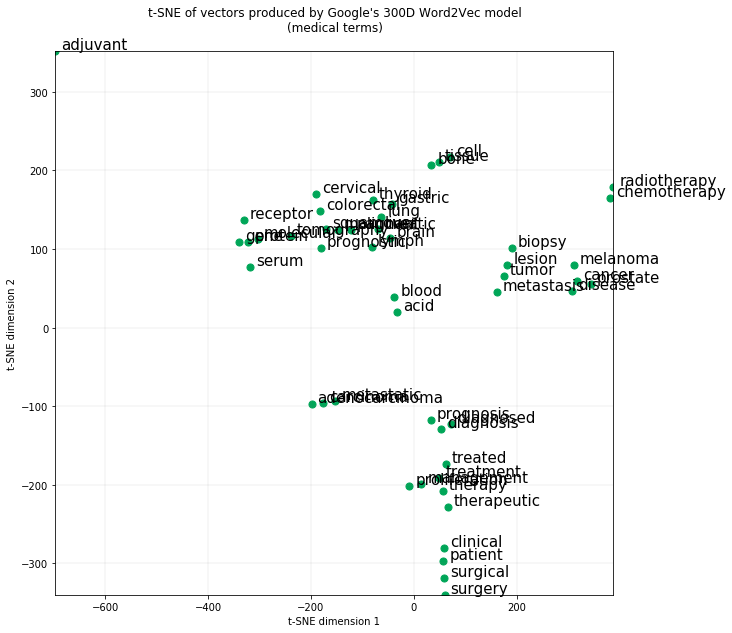

In [0]:
display_tsnescatterplot(gensim_model['gn_wv_model'].wv, medical_words, \
                        "Google's 300D Word2Vec model\n(medical terms)", 300)

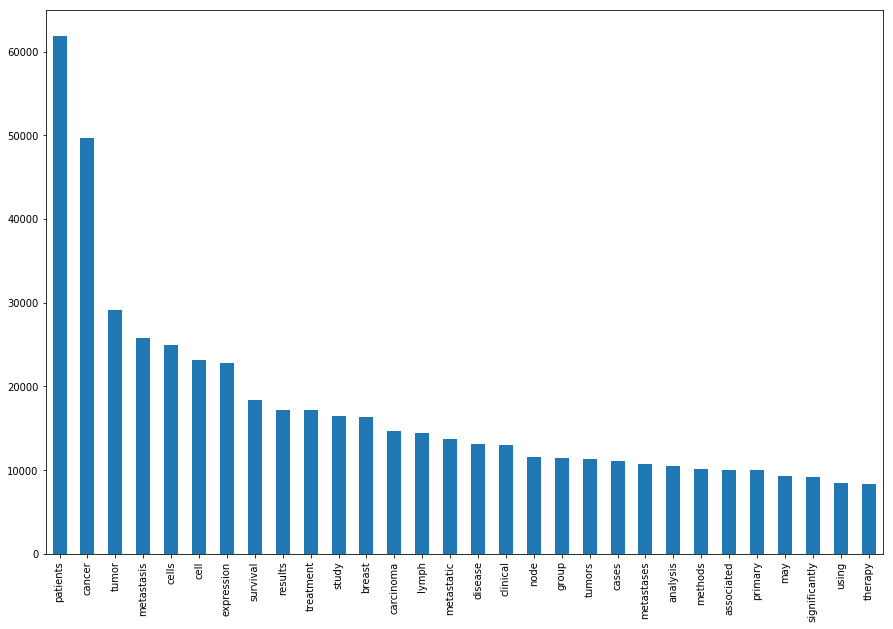

In [0]:
# frequent words histogram
frequent_words = top_frequent_words(gensim_model['ft_sg'], 30)
word_count_dict = dict()
for item in frequent_words:
  word_count_dict[item] = gensim_model['ft_sg'].wv.vocab[item].count
word_count_df = pd.Series(word_count_dict, index=word_count_dict.keys()) 
word_count_df.plot(kind='bar', figsize=(15,10))

##Named Entity Recognition

In [0]:
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

In [0]:
# %%time

# sub_articles_er = list()  
# all_sentence = list()
# exclude_entity_label = [ 
#                        #'PERSON', # Person including fictional
#                        #'NORP',    # Nationalities or religious or political groups
#                        #'ORG',     # Companies, agencies, institutions
#                        #'GPE',     # Countries, cities, states 
#                        #'LOC',     # Non-GPE locations, mountain rages, bodies of water
#                        'DATE',    # Absolute or relative dates or periods
#                        'TIME',    # Times smaller than a day
#                        'PERCENT', # Percentage, including '%' 
#                        'MONEY',   # Monetary values, including unit
#                        #'QUANTITY', # Measurements, as of weight or distance
#                        'ORDINAL',  # first, second etc
#                        'CARDINAL'  # Numerals that do not fall under another type
#                        ]   #ref. http://spacy.io.api/annotation         
# for index, row in sub_articles.iterrows():
#   all_sentence.append(row['primary_title'])
#   all_sentence.append(row['abstract'])

# for each_sentence in all_sentence:  
#   if isinstance(each_sentence, float) and np.isnan(each_sentence):
#       continue
#   else :
#     doc = nlp(each_sentence)
#     for X in doc.ents:
#       if X.label_ not in exclude_entity_label:
#         sub_articles_er.extend(tokenize_custom(X.text))  

In [0]:
# tokens = list(itertools.chain(*sentences))
# print(len(tokens)) # 4146797 

# tokens = list(itertools.chain(*sub_articles_er))
# print(len(tokens)) # after NER 1221151

In [0]:
# # NER visualisation for 10 abstracts.
# sample_abstract = ""
# for index, row in sub_articles[0:9].iterrows():
#   sample_abstract += row['abstract']
# displacy.render(nlp(str(sample_abstract)), jupyter=True, style='ent')

##Human-Evaluated Similarity Comparison

In [0]:
def pedersen_to_cosine_sim(pederson_score):
  
  """
  Coverts a Pedersen rating to a cosine similarity.
  """

  if (pederson_score > 3.9):
    cosine_similarity = 1
  elif (pederson_score > 3.5):
    cosine_similarity = 0.77777778
  elif (pederson_score > 3.2):
    cosine_similarity = 0.55555556
  elif (pederson_score > 2.9):
    cosine_similarity = 0.33333333
  elif (pederson_score > 2.5):
    cosine_similarity = 0.11111111
  elif (pederson_score > 2.2):
    cosine_similarity = -0.11111111
  elif (pederson_score > 1.9):
    cosine_similarity = -0.33333333
  elif (pederson_score > 1.5):
    cosine_similarity = -0.55555556
  elif (pederson_score > 1.2):
    cosine_similarity = -0.77777778
  else:
    cosine_similarity = -1

  return cosine_similarity

  
def score_term_pair_similarities(dict_terms_eval, model, model_name):

  """
  For every term pair in an input dictionary, populate its associated
  cosine similarity.
  """
  
  for pair in dict_terms_eval:
    terms = pair.split("-")

    # Use cosine similarity.
    vectorA = model[terms[0]]
    vectorB = model[terms[1]]
    dict_terms_eval[pair] = 1 - spatial.distance.cosine(vectorA, vectorB)
    

  return dict_terms_eval


def similarity_correlation(dict_human_eval, dict_model, allowance):

  """
  Calculate the correlation between the similairity scores of two input
  term pair / score dicitonaries.
  """

  running_total = 0
  num_scores = len(dict_human_eval)
  if num_scores == 0:
    # Something is wrong with the evaluation dictionary passed in.
    return 0

  # Check if each score matches to within +- allowance.
  for pair in dict_human_eval:
    if (dict_model[pair] < (dict_human_eval[pair] + allowance)):
      if (dict_model[pair] > (dict_human_eval[pair] - allowance)):
        running_total = running_total + 1

  return (running_total / num_scores)


def trim_human_eval_dict(dict_human_eval, dict_model, verbose = False):

  """
  Trim an input dictionary whose compound keys elements aren't in *every*
  model being evaluated.
  """

  discard_keys = []
  
  for pair in dict_human_eval:

    terms = pair.split("-")
    bool_discard_pair = False
    
    for model_eval in dict_model:

      bool_found_A = (terms[0] in word_vectors[model_eval])
      bool_found_B = (terms[1] in word_vectors[model_eval])
      bool_either_missing = (not bool_found_A) or (not bool_found_B)
      bool_discard_pair = bool_discard_pair or bool_either_missing
      if (verbose == True):
        print(terms[0] + " in " + model_eval + " = " + str(bool_found_A))
        print(terms[1] + " in " + model_eval + " = " + str(bool_found_B))

    if (bool_discard_pair == True):
      discard_keys.append(terms[0] + "-" + terms[1])
    if (verbose == True):
      print()

  # Discard any non-ubiquitous evaluation pairs.
  dict
  for deletion_target in discard_keys:
    dict_human_eval.pop(deletion_target)

  return dict_human_eval


# Define a dictionary of user-friendly model aliases.
# Also use for similarity comparison results storage.
dictModelAliases = {    
  "wv_cbow": ["Word2Vec (CBOW)", {}],
  "wv_sg": ["Word2Vec (skip-gram)", {}],
  "ft_cbow": ["FastText (CBOW)", {}],
  "ft_sg": ["FastText (skip-gram)", {}],
  "glove": ["GloVe", {}],
  "gn_wv_model": ["Google pre-trained Word2Vec", {}]}

# Use the Pedersen data set as a human evaluated similarity data set.
# Pedersen similarity scale = 1 (low) - 4 (high).
# Pedersen similarity granularity = 0.3333.
PEDERSEN_ALLOWANCE = 0.11111111
dictPhysicianPedersen = {
  "heart-myocardium": 3.3333,
  "stroke-infarct": 3.0000,
  "abortion-miscarriage": 3.0000,
  "delusion-schizophrenia": 3.0000,
  "metastasis-adenocarcinoma": 2.6667,
  "calcification-stenosis": 2.6667,
  "acne-syringe": 2.0000,
  "antibiotic-allergy": 1.6667,
  "cholangiocarcinoma-colonoscopy": 1.3333,
  "appendicitis-osteoporosis": 1.0000,
  "depression-cellulitis": 1.0000,
  "hyperlipidemia-metastasis": 1.0000
}

# Trim non-ubiquitous term pairs.
dictPhysicianPedersen = trim_human_eval_dict(dictPhysicianPedersen, word_vectors, \
                                             verbose = False)

# Convert Pedersens scores to cosine similarities.
for pair in dictPhysicianPedersen:
  dictPhysicianPedersen[pair] = pedersen_to_cosine_sim(dictPhysicianPedersen[pair])

# Collect term pair similarity scores for the all models.
for mdl in word_vectors:

  dictModelAliases[mdl][1] = score_term_pair_similarities(dictPhysicianPedersen.copy(), \
                               word_vectors[mdl], mdl)

# Display results.
print("Quantitative similarity comparison results...\n")
print("Correlation   Model")
print("-----------   -----")
for mdl in gensim_model:
  print("{:6.0%}        {:}".format(similarity_correlation(dictPhysicianPedersen, \
    dictModelAliases[mdl][1], PEDERSEN_ALLOWANCE), dictModelAliases[mdl][0]))


Quantitative similarity comparison results...

Correlation   Model
-----------   -----
   33%        Word2Vec (CBOW)
   11%        Word2Vec (skip-gram)
   22%        FastText (CBOW)
   11%        FastText (skip-gram)
   11%        Google pre-trained Word2Vec


## Similarity Matrix

In [0]:
def produce_sim_matrix(list_medical, model, n_word=3):
  
  # Produce similarity matrix by number of top similarity words
  
  dfSimilarity = pd.DataFrame(columns=np.arange(1, n_word+1), index=list_medical)
  
  for term in list_medical:
    most_similar_word = model.wv.most_similar(term)
    word_list = [most_similar_word[i:i+1][0][0] for i in range(0, n_word)]
    dfSimilarity.loc[term] = word_list
    
  return dfSimilarity

In [0]:
def export_csv(model, n_word=3, model_label="") :
  
  # Export similarity to csv format
  
  export_file = '/content/drive/My Drive/WordAssociation/'+model_label+'_matrix.csv'
  
  word_list = []
  for word in model.wv.vocab:
    word_list.append(word)

  export_df = produce_sim_matrix(word_list, model, n_word)
  export_df.to_csv(export_file, index=True, index_label=str, header=True, mode='a', chunksize=100)

In [0]:
%%time
export_csv(gensim_model['wv_cbow'], 5, 'wv_cbow')

CPU times: user 9min 3s, sys: 15min 41s, total: 24min 45s
Wall time: 6min 14s


In [0]:
%%time
export_csv(gensim_model['wv_sg'], 5, 'wv_sg')

CPU times: user 9min 27s, sys: 16min 22s, total: 25min 50s
Wall time: 6min 30s


In [0]:
%%time
export_csv(gensim_model['ft_cbow'], 5, 'ft_cbow')

CPU times: user 9min 59s, sys: 17min 14s, total: 27min 14s
Wall time: 6min 51s


In [0]:
%%time
export_csv(gensim_model['ft_sg'], 5, 'ft_sg')

CPU times: user 10min 4s, sys: 16min 39s, total: 26min 43s
Wall time: 6min 44s
